In [2]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from scipy import integrate
import AnaUtils as au

In [3]:
Trigs = ['200306_50mVPMT','200309_20mVPMT','200309_10mVPMT','200309_5mVPMT','200309_2mVPMT','200309_1mVPMT']
wDir = '/data/share/KA0206_BarrelDry_DR/'
fWaves = [wDir+iTrig for iTrig in Trigs]
fWaves

['/data/share/KA0206_BarrelDry_DR/200306_50mVPMT',
 '/data/share/KA0206_BarrelDry_DR/200309_20mVPMT',
 '/data/share/KA0206_BarrelDry_DR/200309_10mVPMT',
 '/data/share/KA0206_BarrelDry_DR/200309_5mVPMT',
 '/data/share/KA0206_BarrelDry_DR/200309_2mVPMT',
 '/data/share/KA0206_BarrelDry_DR/200309_1mVPMT']

In [4]:
waveArrs = [au.ReadDDC10_BinWave(iRun) for iRun in fWaves]
waveArrs

[[array([[[-0.00158691,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ]],
  
         [[ 0.00219727,  0.0020752 ,  0.00244141, ...,  0.00219727,
            0.00183105,  0.0020752 ]],
  
         [[ 0.00231934,  0.00183105,  0.00231934, ...,  0.0020752 ,
            0.00244141,  0.00231934]],
  
         ...,
  
         [[ 0.00219727,  0.00231934,  0.00231934, ...,  0.00231934,
            0.00219727,  0.00231934]],
  
         [[ 0.00231934,  0.00219727,  0.0020752 , ...,  0.00231934,
            0.0020752 ,  0.00195312]],
  
         [[ 0.00244141,  0.0020752 ,  0.00231934, ...,  0.00244141,
            0.00244141,  0.00231934]]]),
  {'numEvents': 100000,
   'numSamples': 350,
   'chMap': array([1]),
   'numChan': 1,
   'liveTimes_s': array([4.00833333e-06, 2.10967638e-01, 1.06520550e-02, ...,
          1.59492615e-01, 1.50575300e-02, 2.79760202e-01]),
   'totliveTime_s': 10508.170557828333}],
 [array([[[0.00244141, 0.00195312, 0.0020752 , ..., 0.001

In [19]:
def getChargeHist(wave,waveinfo,init=175,iend=230,nBins=10000,hrange=[-10,250]):
    wave = au.Subtract_Baseline(wave)[0]
    qArr = 1e3*integrate.simps(wave[...,init:iend],axis=2)
    qArr *=au.sampleWidth_ns/au.resistance_ohm
    return np.histogram(qArr,bins=nBins,range=hrange,weights=np.ones(shape=qArr.shape)/waveinfo['totliveTime_s'])

In [20]:
waveArrs[0][0].shape

(100000, 1, 350)

In [22]:
qHist = None
qHistEdges = None
for iWave in waveArrs:
    #print(iWave[0])
    if not isinstance(qHist,np.ndarray):
        qHist,qHistEdges = getChargeHist(iWave[0],iWave[1])
    else:
        qHist += getChargeHist(iWave[0],iWave[1])[0]

Text(0, 0.5, 'Rate [Hz]')

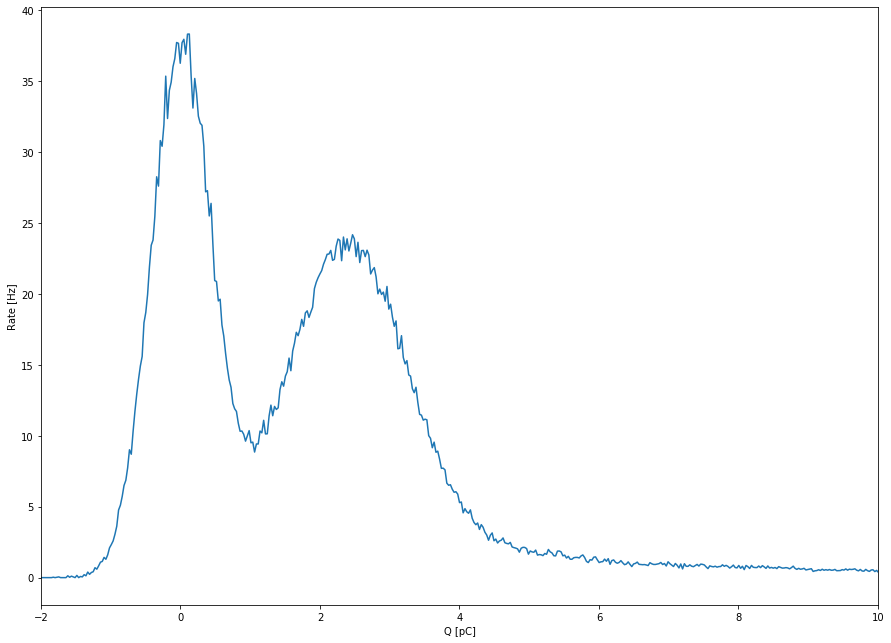

In [23]:
plt.plot((qHistEdges[1:]+qHistEdges[:-1])/2,qHist)
#plt.yscale('log')
plt.xlim(-2,10)
plt.xlabel('Q [pC]')
plt.ylabel('Rate [Hz]')

In [27]:
#1pC bin
bin1pc = np.argmax(qHistEdges>1)
bin10pc = np.argmax(qHistEdges>10)
bin1pc

424

In [29]:
print('Integrated Rate > 1pC = '+str(np.sum(qHist[bin1pc:]))+' Hz')

Integrated Rate > 1pC = 2361.820392288264 Hz


In [ ]:
from scipy.optimize import curve_fit
